<a href="https://colab.research.google.com/github/shohan007/ML-Engineered-Tissue-Evaluation/blob/main/Differentiation_%26_DIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [17]:
#Reading the Dataset
df=pd.read_excel('/content/drive/MyDrive/DIS Data/Differentiation study hasc 0.5M GelMA.xlsx')
df=df.iloc[:,:-2]
#df.head()

dataset_1=df[df['Day']<=11]
dataset_1.head()

,Design,Sample,174kHz,224kHz,287kHz,368kHz,473kHz,607kHz,779kHz,1000kHz,1284kHz,1648kHz,2115kHz,DeltaP,Day
0,1,1,-0.141,-0.343,-0.929,-1.064,-1.174,-1.397,-1.451,-1.561,-1.457,-1.647,-1.520,1.506,1
1,1,1,-0.281,-0.420,-1.021,-1.100,-1.294,-1.400,-1.481,-1.525,-1.437,-1.554,-1.511,1.273,1
2,1,1,-0.209,-0.259,-1.063,-1.027,-1.183,-1.424,-1.557,-1.593,-1.482,-1.574,-1.499,1.384,1
3,1,1,-0.164,-0.628,-0.890,-0.952,-1.262,-1.397,-1.523,-1.581,-1.446,-1.680,-1.589,1.516,1
4,1,1,-0.178,-0.495,-0.882,-0.999,-1.264,-1.400,-1.487,-1.571,-1.522,-1.597,-1.606,1.428,1


In [18]:
dataset_1

,Design,Sample,174kHz,224kHz,287kHz,368kHz,473kHz,607kHz,779kHz,1000kHz,1284kHz,1648kHz,2115kHz,DeltaP,Day
0,1,1,-0.141,-0.343,-0.929,-1.064,-1.174,-1.397,-1.451,-1.561,-1.457,-1.647,-1.520,1.506,1
1,1,1,-0.281,-0.420,-1.021,-1.100,-1.294,-1.400,-1.481,-1.525,-1.437,-1.554,-1.511,1.273,1
2,1,1,-0.209,-0.259,-1.063,-1.027,-1.183,-1.424,-1.557,-1.593,-1.482,-1.574,-1.499,1.384,1
3,1,1,-0.164,-0.628,-0.890,-0.952,-1.262,-1.397,-1.523,-1.581,-1.446,-1.680,-1.589,1.516,1
4,1,1,-0.178,-0.495,-0.882,-0.999,-1.264,-1.400,-1.487,-1.571,-1.522,-1.597,-1.606,1.428,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,4,12,2.165,1.016,0.219,0.184,-0.447,-0.425,-0.470,-0.610,-0.565,-0.622,-0.641,2.806,11
2636,4,12,1.866,0.879,0.319,-0.008,-0.060,-0.373,-0.493,-0.551,-0.575,-0.536,-0.659,2.525,11
2637,4,12,1.707,0.891,0.180,0.095,-0.292,-0.359,-0.431,-0.618,-0.564,-0.622,-0.667,2.374,11
2638,4,12,2.116,0.822,0.535,-0.058,-0.198,-0.425,-0.457,-0.582,-0.559,-0.583,-0.587,2.703,11


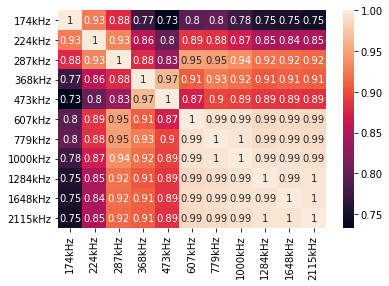

In [19]:
#Dataset Preprocessing

X=dataset_1.iloc[:,2:13]
Y=dataset_1[['Design','Sample','Day']]
#Heatmap
sns.heatmap(X.corr(), annot=True);
#sns.pairplot(X)

In [ ]:
#Normalizing the Data
le1=LabelEncoder()
scaler=StandardScaler()

X_transformed=scaler.fit_transform(X)
Y_transformed_Design=Y['Design']

## Parametric Variation Detection

In [ ]:
# confusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Grid search

def grid_search(clf, parameters, scorer, train_data, test_data, cv=5):

    #Perform grid search on the classifier using 'scorer' as the scoring method.
    grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters.
    grid_fit = grid_obj.fit(train_data[0], train_data[1])

    # Get the estimator.
    best_clf = grid_fit.best_estimator_

    # Fit the new model.
    best_clf.fit(train_data[0], train_data[1])

    # Make predictions using the new model.
    best_train_predictions = best_clf.predict(train_data[0])
    best_test_predictions = best_clf.predict(test_data[0])

    # Calculate the acc score of the new model.
    print('The training acc Score is', accuracy_score(best_train_predictions, train_data[1]))
    print('The testing acc Score is', accuracy_score(best_test_predictions, test_data[1]))
    print('The testing acc Score STD', np.mean(grid_obj.cv_results_['std_test_score']))


    # Let's also explore what parameters ended up being used in the new model.
    return grid_obj, best_clf

#Function of SML models

In [ ]:
# Logistics Regression with cross validation
def logistic_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    parameters = {'C':[1.0, 10, 100, 1000]}
    scorer = make_scorer(accuracy_score)
    logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10_000) 
    
    # grid search
    grid_obj, best_clf = grid_search(logreg, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [ ]:
# Support vector machine with cross validation
def svc_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    svc = SVC() 
    parameters = {'kernel':['linear', 'poly', 'rbf'],'C':[0.01, 0.1, 0.5, 1, 5,10]}
    scorer = make_scorer(accuracy_score)
   

    # grisearch
    grid_obj, best_clf = grid_search(svc, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [ ]:
# K Nearest Neighbours with cross validation
def knn_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    knn = KNeighborsClassifier()
    neighbors = list(range(1, 30))  
    parameters = {'n_neighbors': neighbors}
    scorer = make_scorer(accuracy_score)
 
    # grisearch
    grid_obj, best_clf = grid_search(knn, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)
    print(best_clf)

In [ ]:
# Random Forest with cross validation
def rf_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    rf= RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(rf, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [ ]:
# Train Test Dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_Design,
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y_transformed_Design)


# create class names
class_names = np.unique(Y['Design'])
class_names = [c for c in class_names]

The training acc Score is 0.38961038961038963
The testing acc Score is 0.37752525252525254
The testing acc Score STD 0.023039529649991192
              precision    recall  f1-score   support

           1       0.43      0.45      0.44       198
           2       0.29      0.28      0.29       198
           3       0.34      0.25      0.29       198
           4       0.42      0.52      0.47       198

    accuracy                           0.38       792
   macro avg       0.37      0.38      0.37       792
weighted avg       0.37      0.38      0.37       792



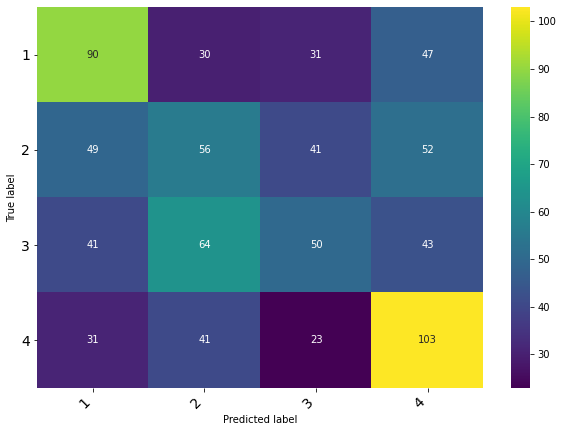

In [ ]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.6336580086580087
The testing acc Score is 0.6060606060606061
The testing acc Score STD 0.023798399399829473
              precision    recall  f1-score   support

           1       0.60      0.60      0.60       198
           2       0.69      0.43      0.53       198
           3       0.59      0.59      0.59       198
           4       0.59      0.80      0.68       198

    accuracy                           0.61       792
   macro avg       0.62      0.61      0.60       792
weighted avg       0.62      0.61      0.60       792



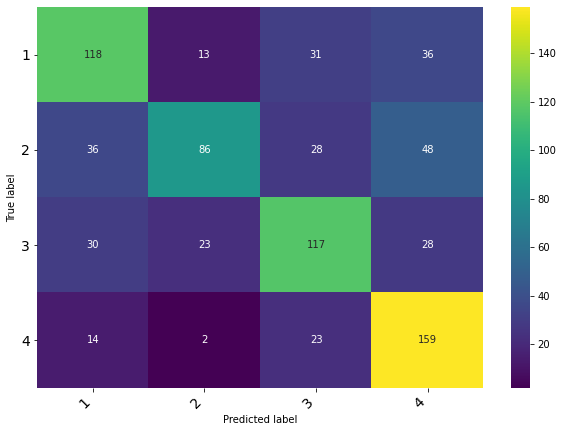

In [ ]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9128787878787878
The testing acc Score is 0.8585858585858586
The testing acc Score STD 0.011748938362468245
              precision    recall  f1-score   support

           1       0.90      0.84      0.87       198
           2       0.89      0.90      0.90       198
           3       0.86      0.79      0.82       198
           4       0.80      0.90      0.85       198

    accuracy                           0.86       792
   macro avg       0.86      0.86      0.86       792
weighted avg       0.86      0.86      0.86       792

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


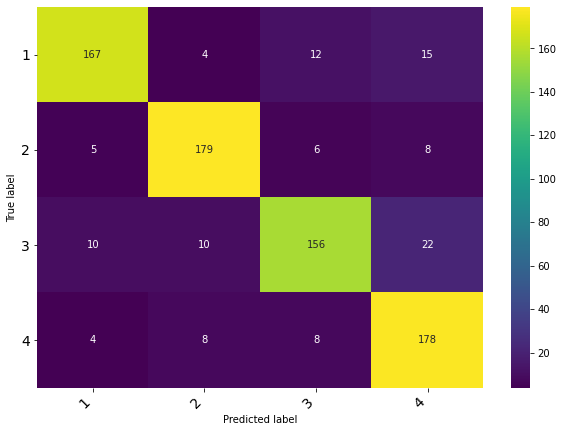

In [ ]:
# knn
knn_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9940476190476191
The testing acc Score is 0.8194444444444444
The testing acc Score STD 0.007256350720709894
              precision    recall  f1-score   support

           1       0.80      0.79      0.80       198
           2       0.86      0.87      0.86       198
           3       0.80      0.77      0.78       198
           4       0.82      0.84      0.83       198

    accuracy                           0.82       792
   macro avg       0.82      0.82      0.82       792
weighted avg       0.82      0.82      0.82       792



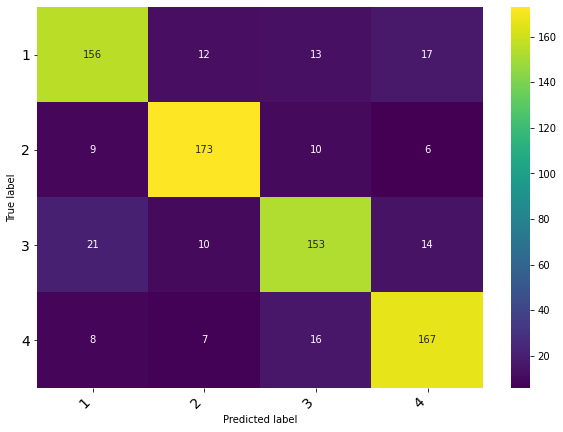

In [ ]:
# random forest
rf_cv((trainx, trainy), (testx, testy), class_names, 10)

#Differentiation study

###Evaluation before differentiation

In [22]:
#Parametric variation evaluation before differentiation

dataset_2=df[df['Sample']>6]
dataset_2=dataset_2.loc[dataset_2['Day'].isin([1,3,5,7,9])]
dataset_2.head()

#Dataset Preparation
sample7=dataset_2[dataset_2['Sample']==7]
sample8=dataset_2[dataset_2['Sample']==8]
sample9=dataset_2[dataset_2['Sample']==9]
sample10=dataset_2[dataset_2['Sample']==10]
sample11=dataset_2[dataset_2['Sample']==11]
sample12=dataset_2[dataset_2['Sample']==12]

lower_freq_df=pd.DataFrame()
lower_freq_df['Chondrogenic_S7@174kHZ']=sample7['174kHz']
lower_freq_df['Osteogenic_S8@174kHZ']=sample8['174kHz'].values
lower_freq_df['Control_hasc_S9@174kHZ']=sample9['174kHz'].values
lower_freq_df['Chondrogenic_S10@174kHZ']=sample10['174kHz'].values
lower_freq_df['Osteogenic_S11@174kHZ']=sample11['174kHz'].values
lower_freq_df['Control_hasc_S12@174kHZ']=sample12['174kHz'].values
lower_freq_df['Day']=sample7['Day']
lower_freq_df.set_index('Day',inplace=True)
#lower_freq_df.head()

higher_freq_df=pd.DataFrame()
higher_freq_df['Chondrogenic_S7@2115kHZ']=sample7['2115kHz']
higher_freq_df['Osteogenic_S8@2115kHZ']=sample8['2115kHz'].values
higher_freq_df['Control_hasc_S9@2115kHZ']=sample9['2115kHz'].values
higher_freq_df['Chondrogenic_S10@2115kHZ']=sample10['2115kHz'].values
higher_freq_df['Osteogenic_S11@2115kHZ']=sample11['2115kHz'].values
higher_freq_df['Control_hasc_S12@2115kHZ']=sample12['2115kHz'].values
higher_freq_df['Day']=sample7['Day']
higher_freq_df.set_index('Day',inplace=True)
#higher_freq_df.head()

medium_freq_df=pd.DataFrame()
medium_freq_df['Chondrogenic_S7@607kHZ']=sample7['607kHz']
medium_freq_df['Osteogenic_S8@607kHZ']=sample8['607kHz'].values
medium_freq_df['Control_hasc_S9@607kHZ']=sample9['607kHz'].values
medium_freq_df['Chondrogenic_S10@607kHZ']=sample10['607kHz'].values
medium_freq_df['Osteogenic_S11@607kHZ']=sample11['607kHz'].values
medium_freq_df['Control_hasc_S12@607kHZ']=sample12['607kHz'].values
medium_freq_df['Day']=sample7['Day']
medium_freq_df.set_index('Day',inplace=True)
medium_freq_df.head()

,Chondrogenic_S7@607kHZ,Osteogenic_S8@607kHZ,Control_hasc_S9@607kHZ,Chondrogenic_S10@607kHZ,Osteogenic_S11@607kHZ,Control_hasc_S12@607kHZ
Day,,,,,,
1,-1.100,-1.358,-0.780,-0.853,-1.046,-1.022
1,-1.123,-1.289,-0.776,-0.831,-0.989,-0.974
1,-1.151,-1.332,-0.713,-0.886,-1.050,-0.924
1,-1.117,-1.314,-0.650,-0.827,-1.056,-0.974
1,-1.179,-1.325,-0.713,-0.852,-1.068,-0.982


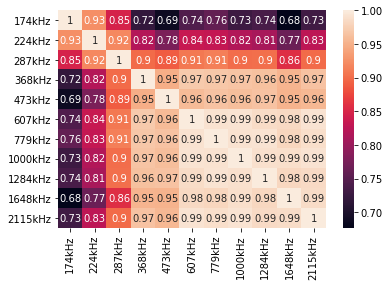

In [24]:
#Dataset Preprocessing

X=dataset_2.iloc[:,2:13]
Y=dataset_2[['Design','Sample','Day']]
#Heatmap
sns.heatmap(X.corr(), annot=True);
#sns.pairplot(X)


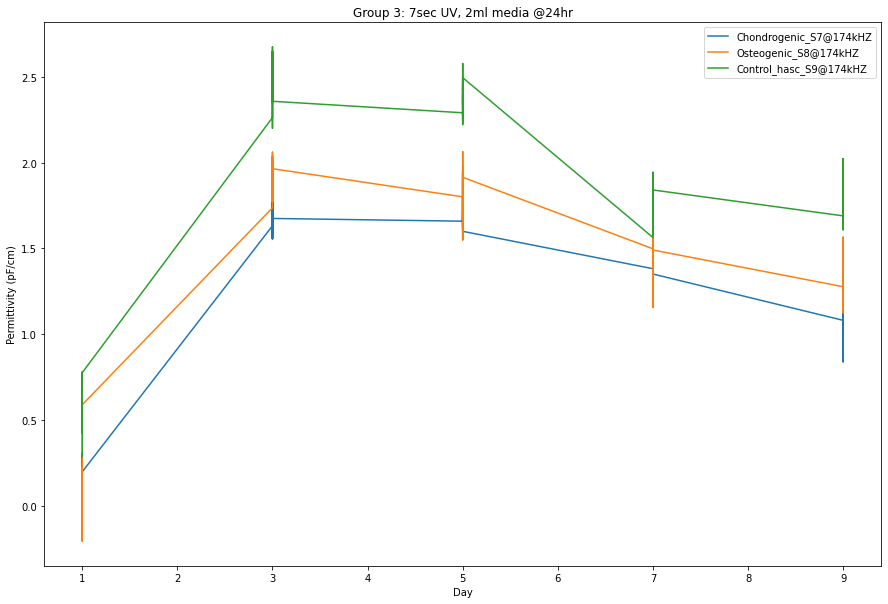

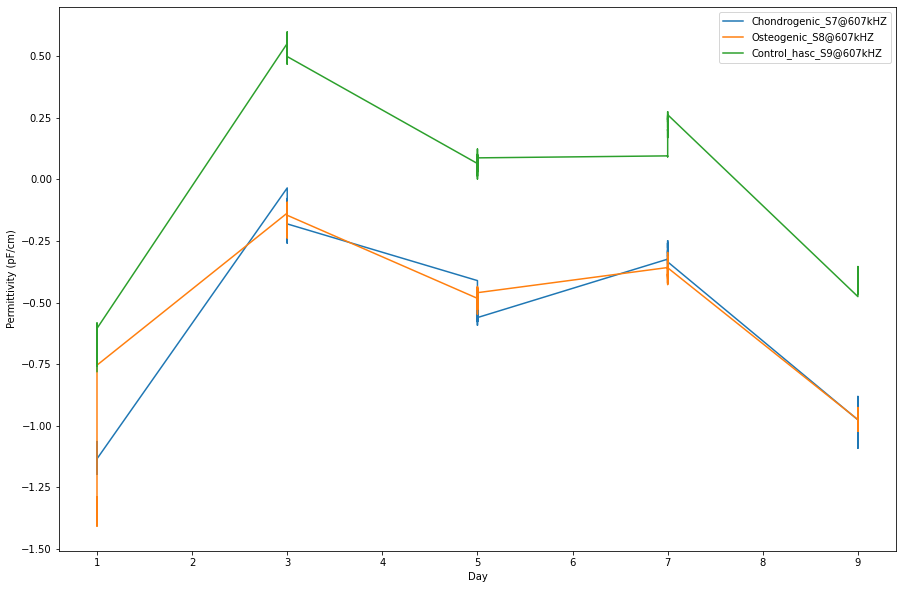

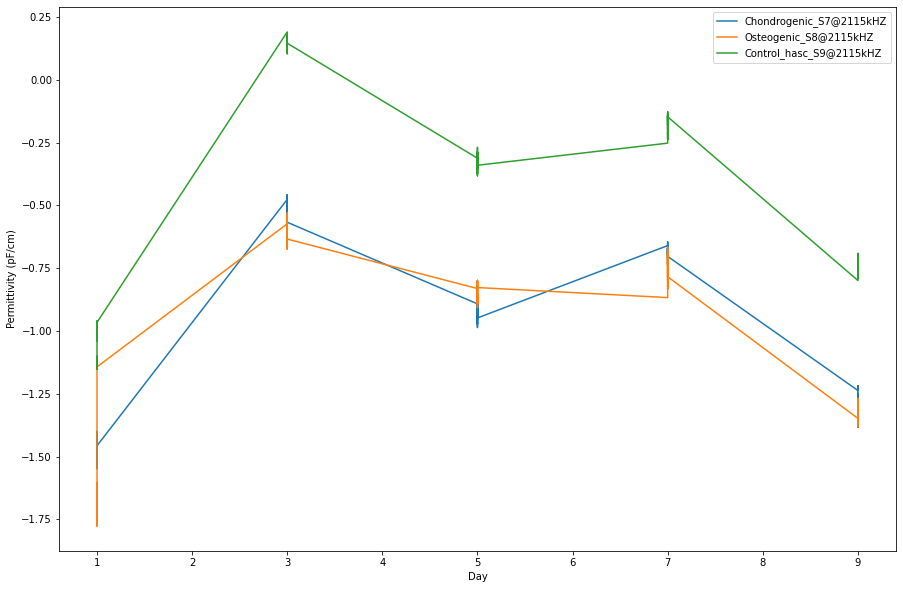

In [ ]:
#Group 3
lower_freq_group3=lower_freq_df[['Chondrogenic_S7@174kHZ','Osteogenic_S8@174kHZ','Control_hasc_S9@174kHZ']]
medium_freq_group3=medium_freq_df[['Chondrogenic_S7@607kHZ','Osteogenic_S8@607kHZ','Control_hasc_S9@607kHZ']]
higher_freq_group3=higher_freq_df[['Chondrogenic_S7@2115kHZ','Osteogenic_S8@2115kHZ','Control_hasc_S9@2115kHZ']]
#higher_freq_group3.head()

lower_freq_group3.plot(figsize=(15,10),ylabel='Permittivity (pF/cm)',title='Group 3: 7sec UV, 2ml media @24hr');
medium_freq_group3.plot(figsize=(15,10),ylabel='Permittivity (pF/cm)');
higher_freq_group3.plot(figsize=(15,10),ylabel='Permittivity (pF/cm)');

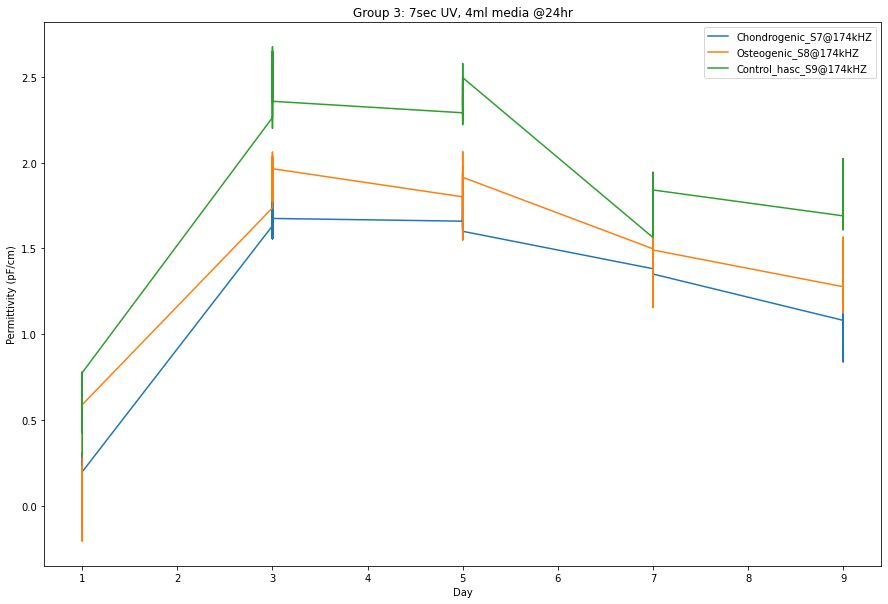

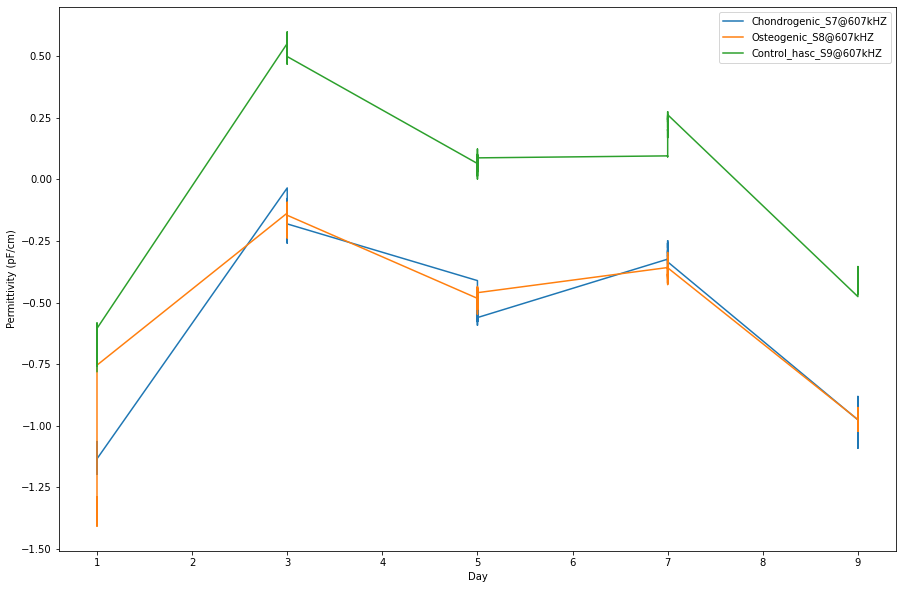

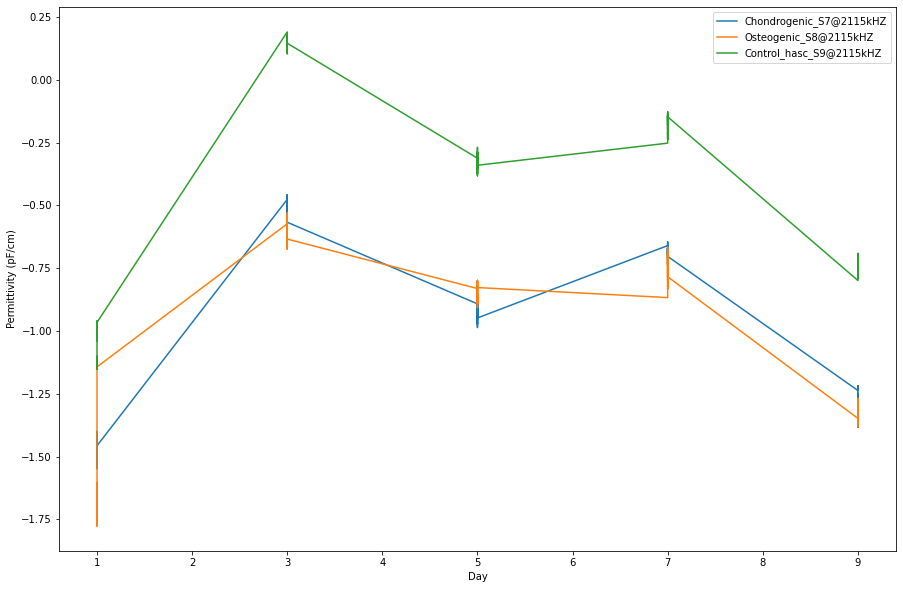

In [ ]:
#Group 4
lower_freq_group4=lower_freq_df[['Chondrogenic_S7@174kHZ','Osteogenic_S8@174kHZ','Control_hasc_S9@174kHZ']]
medium_freq_group4=medium_freq_df[['Chondrogenic_S7@607kHZ','Osteogenic_S8@607kHZ','Control_hasc_S9@607kHZ']]
higher_freq_group4=higher_freq_df[['Chondrogenic_S7@2115kHZ','Osteogenic_S8@2115kHZ','Control_hasc_S9@2115kHZ']]
#higher_freq_group4.head()

lower_freq_group4.plot(figsize=(15,10),ylabel='Permittivity (pF/cm)', title='Group 3: 7sec UV, 4ml media @24hr');
medium_freq_group4.plot(figsize=(15,10),ylabel='Permittivity (pF/cm)');
higher_freq_group4.plot(figsize=(15,10),ylabel='Permittivity (pF/cm)');

##Evaluation after differentiation

In [ ]:
#Evaluation afer differentiation

dataset_3=df[df['Sample']>6]
dataset_3=dataset_3.loc[dataset_3['Day'].isin([11,14,17,20,23,26,29])]
dataset_3.head()

#Dataset Preparation
sample7=dataset_3[dataset_3['Sample']==7]
sample8=dataset_3[dataset_3['Sample']==8]
sample9=dataset_3[dataset_3['Sample']==9]
sample10=dataset_3[dataset_3['Sample']==10]
sample11=dataset_3[dataset_3['Sample']==11]
sample12=dataset_3[dataset_3['Sample']==12]

lower_freq_df=pd.DataFrame()
lower_freq_df['Chondrogenic_S7@174kHZ']=sample7['Average Zeroed Cap@174kHz']
lower_freq_df['Osteogenic_S8@174kHZ']=sample8['Average Zeroed Cap@174kHz'].values
lower_freq_df['Control_hasc_S9@174kHZ']=sample9['Average Zeroed Cap@174kHz'].values
lower_freq_df['Chondrogenic_S10@174kHZ']=sample10['Average Zeroed Cap@174kHz'].values
lower_freq_df['Osteogenic_S11@174kHZ']=sample11['Average Zeroed Cap@174kHz'].values
lower_freq_df['Control_hasc_S12@174kHZ']=sample12['Average Zeroed Cap@174kHz'].values
lower_freq_df['Day']=sample7['Day']
lower_freq_df.set_index('Day',inplace=True)
#lower_freq_df.head()

higher_freq_df=pd.DataFrame()
higher_freq_df['Chondrogenic_S7@2115kHZ']=sample7['Average Zeroed Cap@2115kHz']
higher_freq_df['Osteogenic_S8@2115kHZ']=sample8['Average Zeroed Cap@2115kHz'].values
higher_freq_df['Control_hasc_S9@2115kHZ']=sample9['Average Zeroed Cap@2115kHz'].values
higher_freq_df['Chondrogenic_S10@2115kHZ']=sample10['Average Zeroed Cap@2115kHz'].values
higher_freq_df['Osteogenic_S11@2115kHZ']=sample11['Average Zeroed Cap@2115kHz'].values
higher_freq_df['Control_hasc_S12@2115kHZ']=sample12['Average Zeroed Cap@2115kHz'].values
higher_freq_df['Day']=sample7['Day']
higher_freq_df.set_index('Day',inplace=True)
#higher_freq_df.head()

medium_freq_df=pd.DataFrame()
medium_freq_df['Chondrogenic_S7@607kHZ']=sample7['Average Zeroed Cap@607kHz']
medium_freq_df['Osteogenic_S8@607kHZ']=sample8['Average Zeroed Cap@607kHz'].values
medium_freq_df['Control_hasc_S9@607kHZ']=sample9['Average Zeroed Cap@607kHz'].values
medium_freq_df['Chondrogenic_S10@607kHZ']=sample10['Average Zeroed Cap@607kHz'].values
medium_freq_df['Osteogenic_S11@607kHZ']=sample11['Average Zeroed Cap@607kHz'].values
medium_freq_df['Control_hasc_S12@607kHZ']=sample12['Average Zeroed Cap@607kHz'].values
medium_freq_df['Day']=sample7['Day']
medium_freq_df.set_index('Day',inplace=True)
medium_freq_df.head()

,Chondrogenic_S7@607kHZ,Osteogenic_S8@607kHZ,Control_hasc_S9@607kHZ,Chondrogenic_S10@607kHZ,Osteogenic_S11@607kHZ,Control_hasc_S12@607kHZ
Day,,,,,,
11,-0.344,-0.261,0.324,-0.434,-0.622,-0.345
11,-0.284,-0.379,0.332,-0.466,-0.554,-0.386
11,-0.367,-0.284,0.341,-0.478,-0.605,-0.315
11,-0.315,-0.339,0.346,-0.462,-0.601,-0.280
11,-0.390,-0.305,0.289,-0.493,-0.610,-0.247


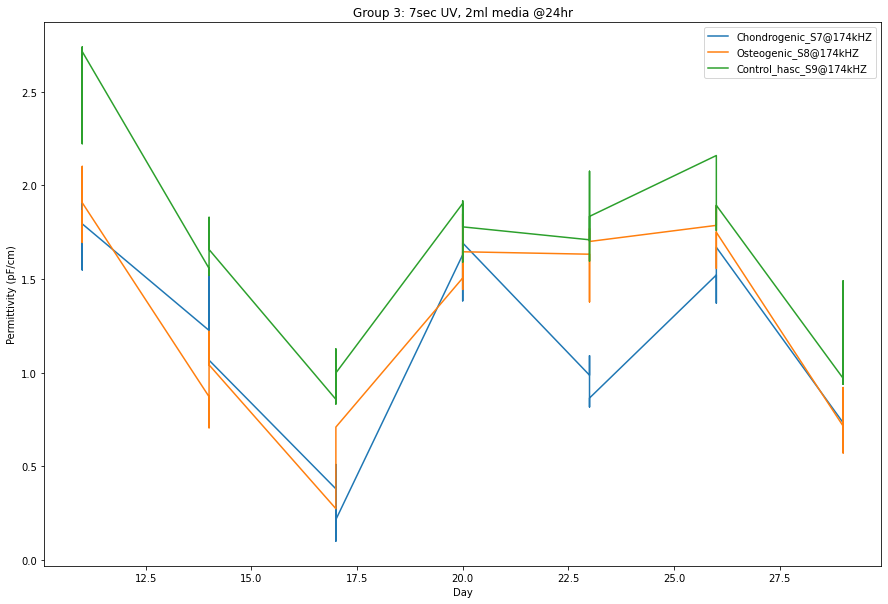

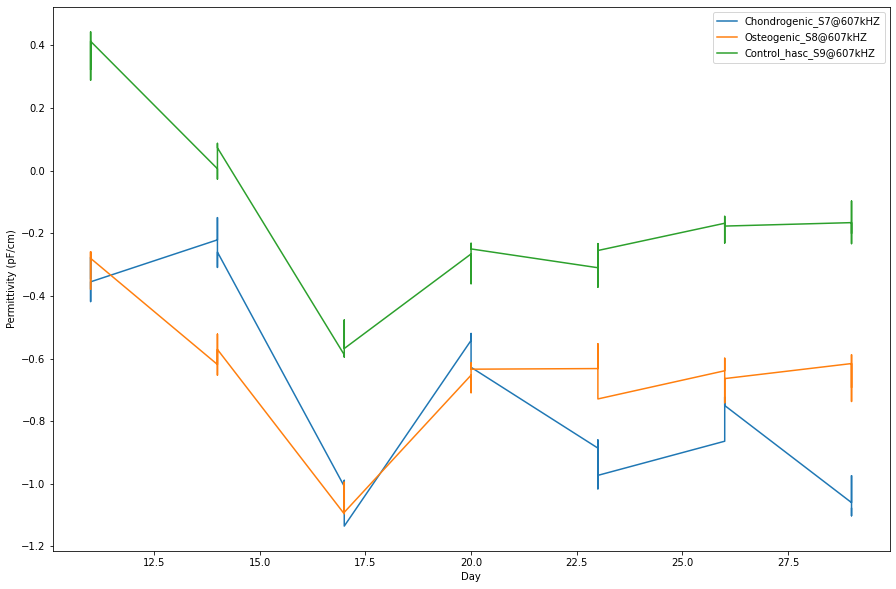

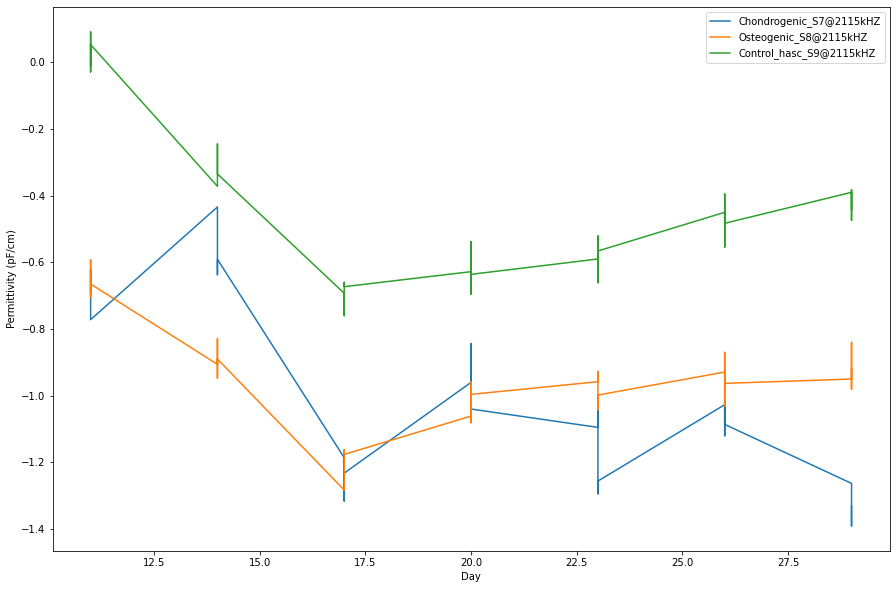

In [ ]:
#Group 3
lower_freq_group3=lower_freq_df[['Chondrogenic_S7@174kHZ','Osteogenic_S8@174kHZ','Control_hasc_S9@174kHZ']]
medium_freq_group3=medium_freq_df[['Chondrogenic_S7@607kHZ','Osteogenic_S8@607kHZ','Control_hasc_S9@607kHZ']]
higher_freq_group3=higher_freq_df[['Chondrogenic_S7@2115kHZ','Osteogenic_S8@2115kHZ','Control_hasc_S9@2115kHZ']]
#higher_freq_group3.head()

lower_freq_group3.plot(figsize=(15,10),ylabel='Permittivity (pF/cm)',title='Group 3: 7sec UV, 2ml media @24hr');
medium_freq_group3.plot(figsize=(15,10),ylabel='Permittivity (pF/cm)');
higher_freq_group3.plot(figsize=(15,10),ylabel='Permittivity (pF/cm)');


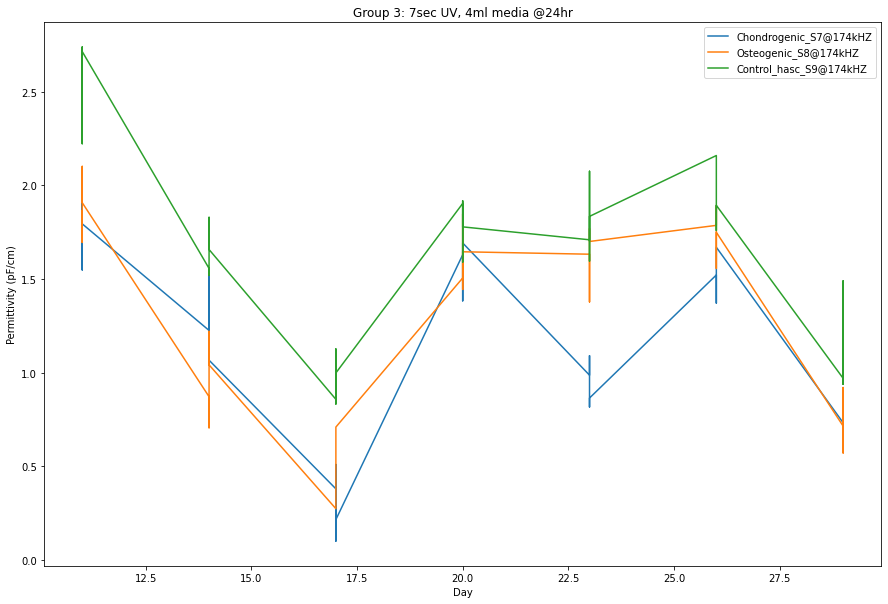

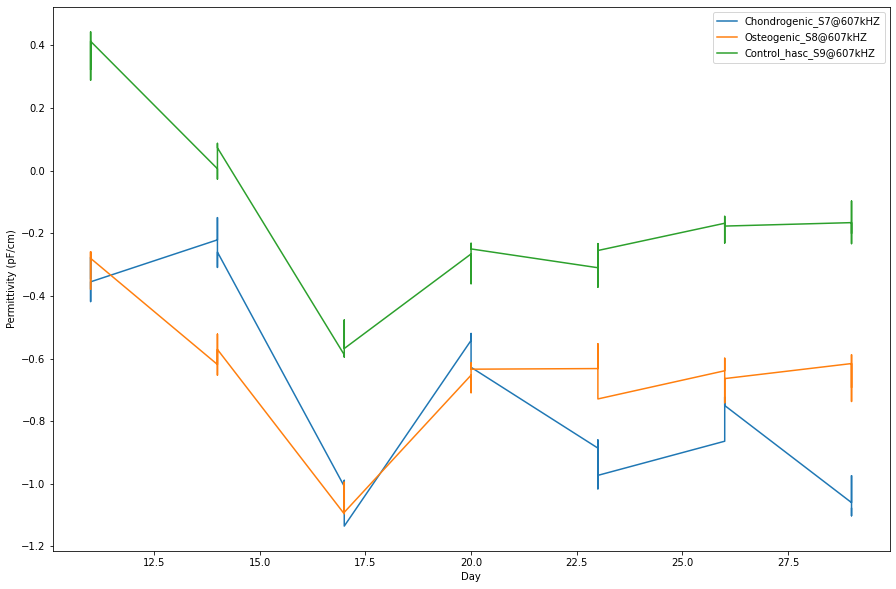

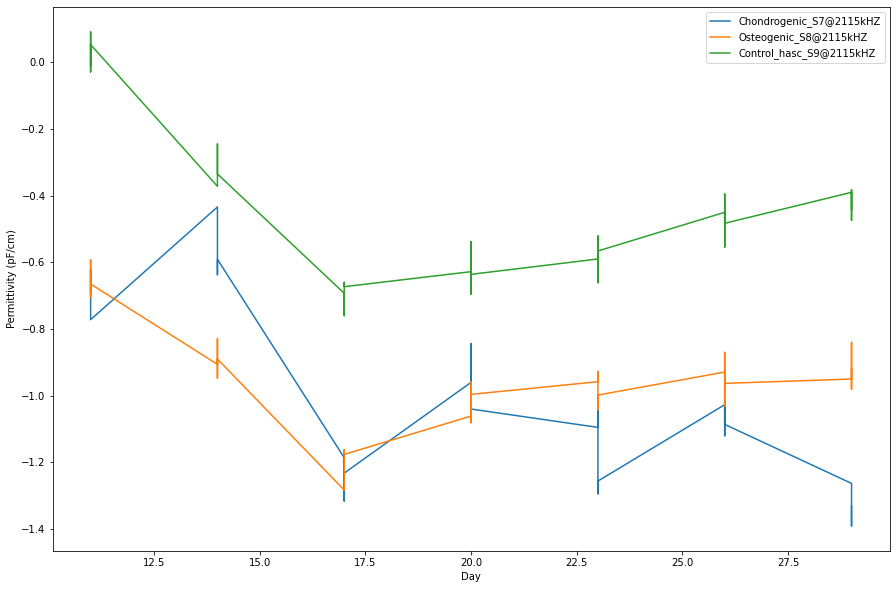

In [ ]:
#Group 4
lower_freq_group4=lower_freq_df[['Chondrogenic_S7@174kHZ','Osteogenic_S8@174kHZ','Control_hasc_S9@174kHZ']]
medium_freq_group4=medium_freq_df[['Chondrogenic_S7@607kHZ','Osteogenic_S8@607kHZ','Control_hasc_S9@607kHZ']]
higher_freq_group4=higher_freq_df[['Chondrogenic_S7@2115kHZ','Osteogenic_S8@2115kHZ','Control_hasc_S9@2115kHZ']]
#higher_freq_group4.head()

lower_freq_group4.plot(figsize=(15,10),ylabel='Permittivity (pF/cm)', title='Group 3: 7sec UV, 4ml media @24hr');
medium_freq_group4.plot(figsize=(15,10),ylabel='Permittivity (pF/cm)');
higher_freq_group4.plot(figsize=(15,10),ylabel='Permittivity (pF/cm)');

##Machine Learning model to detect differentiation of hASC

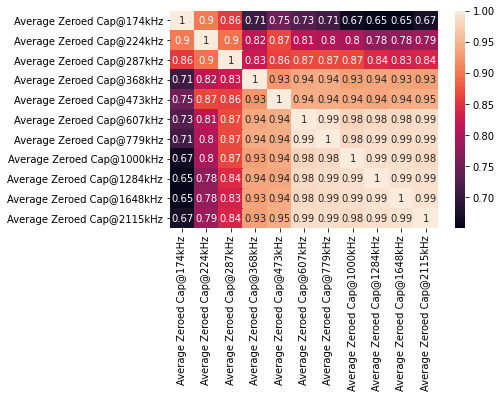

In [ ]:
X=dataset_3.iloc[:,2:13]
Y=dataset_3[['Design','Sample','Day']]
#Heatmap
sns.heatmap(X.corr(), annot=True);

In [ ]:
#Encoding X
scaler=StandardScaler()
X_transformed=scaler.fit_transform(X)
Y_transformed_sample=Y['Day']

In [ ]:
# Train Test Dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_sample,
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y_transformed_sample)


# create class names
class_names = np.unique(Y['Day'])
class_names = [c for c in class_names]

The training acc Score is 0.9727891156462585
The testing acc Score is 0.9325396825396826
The testing acc Score STD 0.01565059809036471
              precision    recall  f1-score   support

          11       0.97      0.97      0.97        36
          14       0.89      0.94      0.92        36
          17       0.95      0.97      0.96        36
          20       0.97      0.92      0.94        36
          23       0.94      0.92      0.93        36
          26       0.92      0.97      0.95        36
          29       0.88      0.83      0.86        36

    accuracy                           0.93       252
   macro avg       0.93      0.93      0.93       252
weighted avg       0.93      0.93      0.93       252



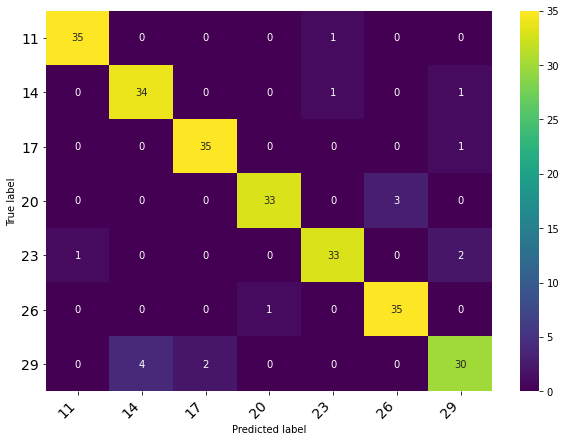

In [ ]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9778911564625851
The testing acc Score is 0.9841269841269841
The testing acc Score STD 0.02759186879033708
              precision    recall  f1-score   support

          11       0.97      1.00      0.99        36
          14       1.00      1.00      1.00        36
          17       1.00      1.00      1.00        36
          20       0.97      0.94      0.96        36
          23       0.97      0.94      0.96        36
          26       0.97      1.00      0.99        36
          29       1.00      1.00      1.00        36

    accuracy                           0.98       252
   macro avg       0.98      0.98      0.98       252
weighted avg       0.98      0.98      0.98       252



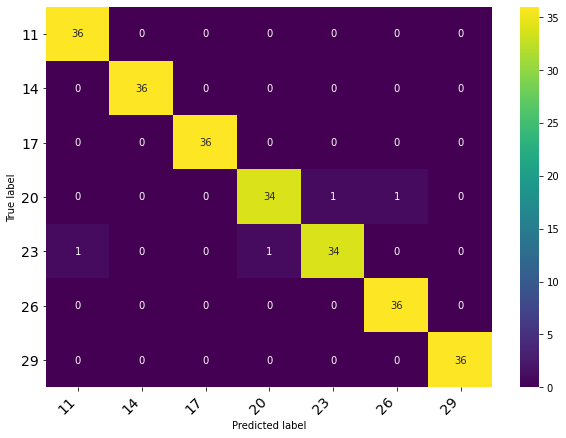

In [ ]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9812925170068028
The testing acc Score is 0.9484126984126984
The testing acc Score STD 0.02671035090365321
              precision    recall  f1-score   support

          11       0.89      0.94      0.92        36
          14       1.00      0.94      0.97        36
          17       1.00      1.00      1.00        36
          20       0.94      0.89      0.91        36
          23       0.91      0.86      0.89        36
          26       0.95      1.00      0.97        36
          29       0.95      1.00      0.97        36

    accuracy                           0.95       252
   macro avg       0.95      0.95      0.95       252
weighted avg       0.95      0.95      0.95       252

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')


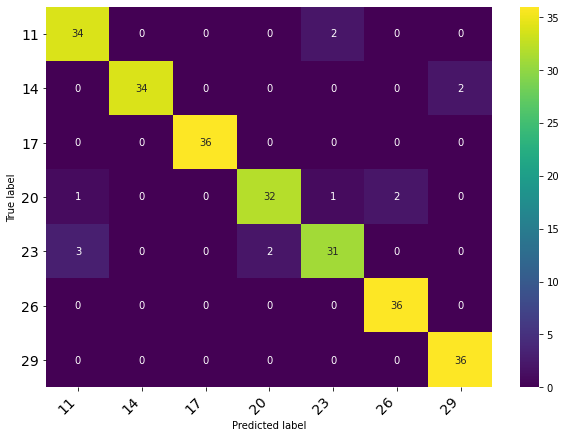

In [ ]:
# knn
knn_cv((trainx, trainy), (testx, testy), class_names, 10)


The training acc Score is 0.9982993197278912
The testing acc Score is 0.9484126984126984
The testing acc Score STD 0.023981292849438104
              precision    recall  f1-score   support

          11       1.00      1.00      1.00        36
          14       0.92      0.92      0.92        36
          17       0.95      0.97      0.96        36
          20       0.97      0.97      0.97        36
          23       0.97      0.89      0.93        36
          26       0.97      0.94      0.96        36
          29       0.87      0.94      0.91        36

    accuracy                           0.95       252
   macro avg       0.95      0.95      0.95       252
weighted avg       0.95      0.95      0.95       252



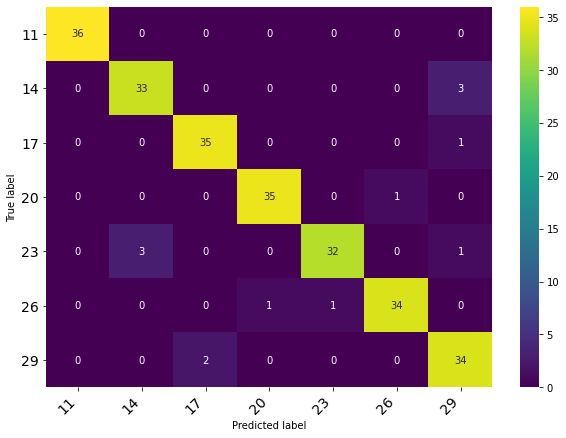

In [ ]:
# rf
rf_cv((trainx, trainy), (testx, testy), class_names, 10)